In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import quadpy

from math import exp, pi, cos, sin, atan
from numba import jit, prange

In [2]:
warnings.filterwarnings("ignore")

In [3]:
std = 0.2


@jit(nopython=True, parallel=True)
def eta_aux(x, res):
    for i in prange(x.shape[0]):
        squared_norm = x[i, 0] ** 2 + x[i, 1] ** 2
        res[i] += exp(-squared_norm / (2 * std**2))


def eta(x):
    if x.ndim == 1:
        tmp = np.zeros(1)
        eta_aux(np.reshape(x, (1, 2)), tmp)
        res = tmp[0]
    else:
        res = np.zeros(x.shape[0])
        eta_aux(x, res)
    return res

In [4]:
def rot(theta):
    return np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])

In [5]:
a = np.array([0.5, 0.2])
b = np.array([0, 0.4])
c_ref = b + rot(-pi/3) @ (b-a)
# c_ref = np.array([-0.75, 0.3])
c = b + (c_ref - b) * 0.25
o = np.array([0, 0])

points = np.vstack([a, b, c_ref, c, o])

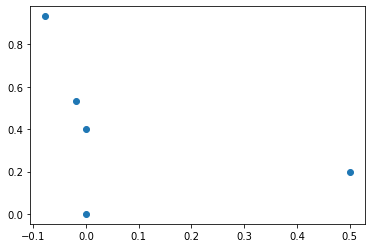

In [6]:
plt.scatter(points[:, 0], points[:, 1])

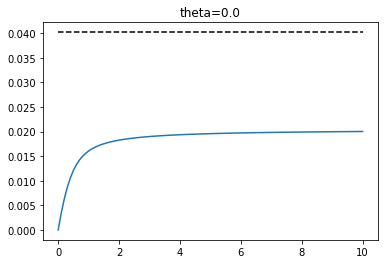

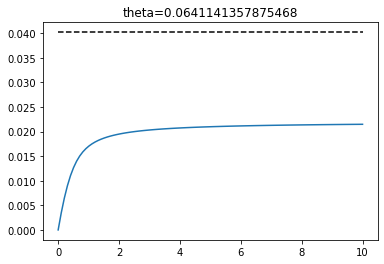

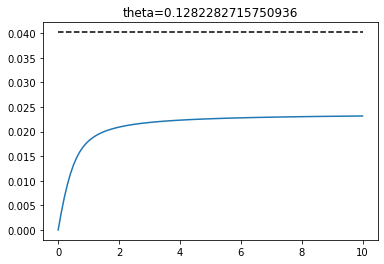

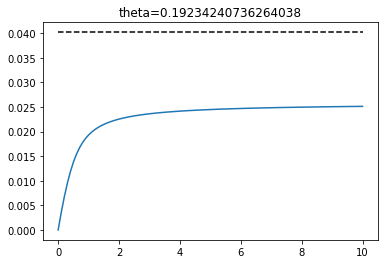

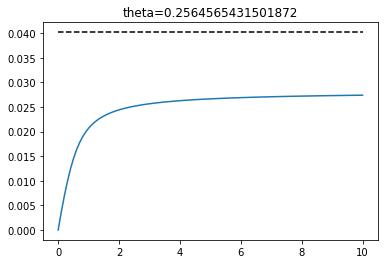

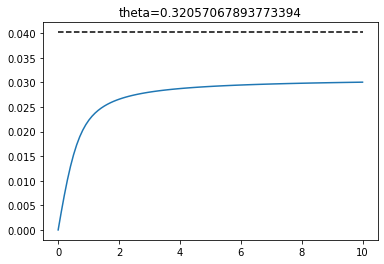

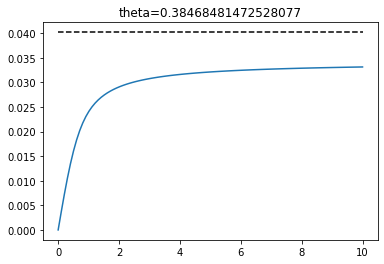

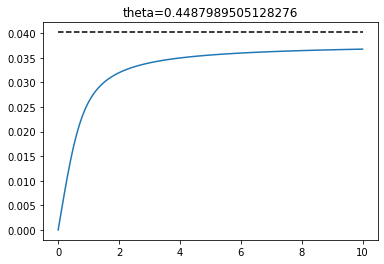

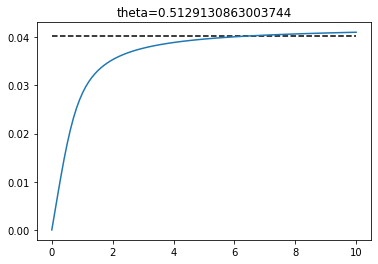

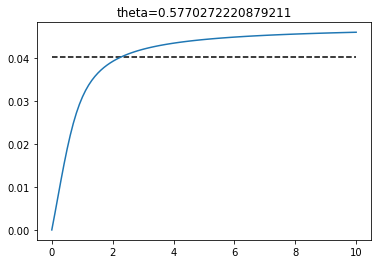

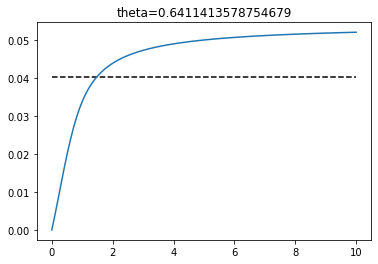

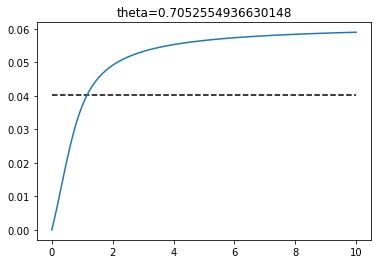

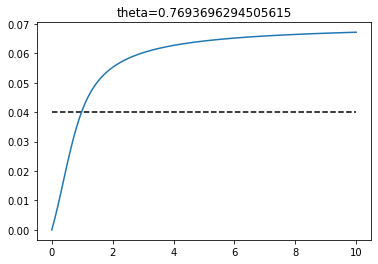

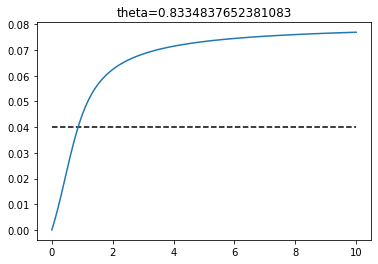

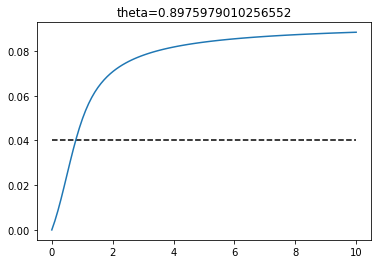

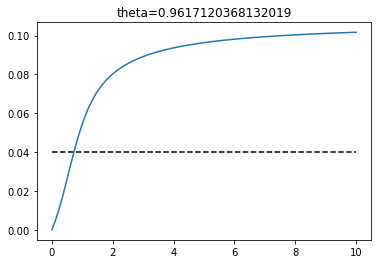

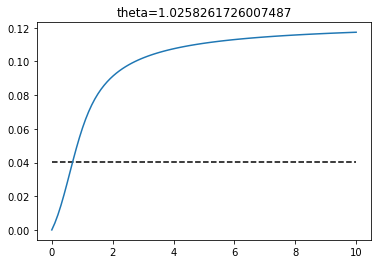

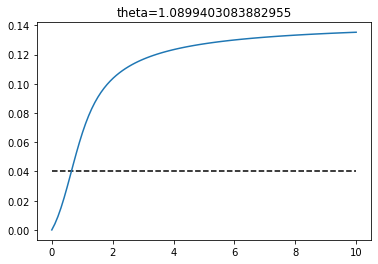

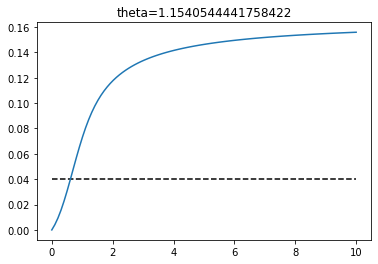

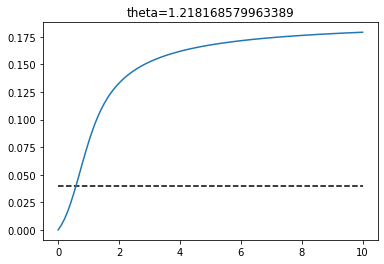

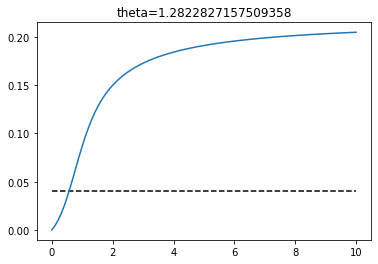

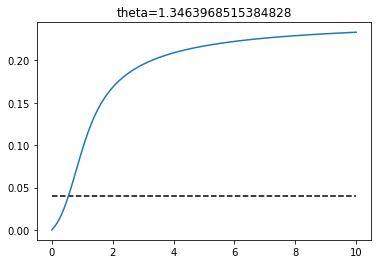

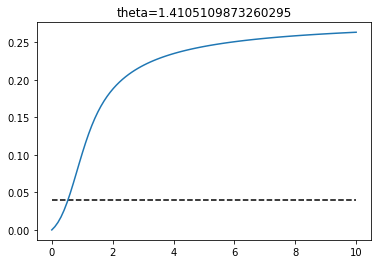

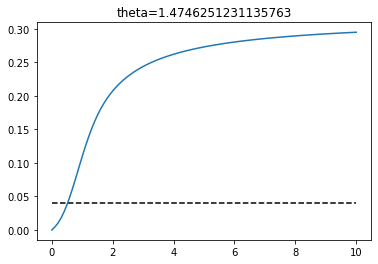

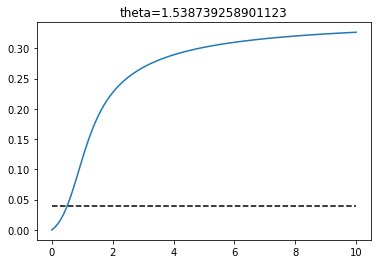

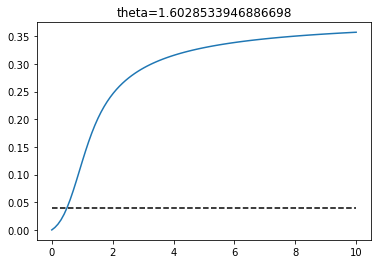

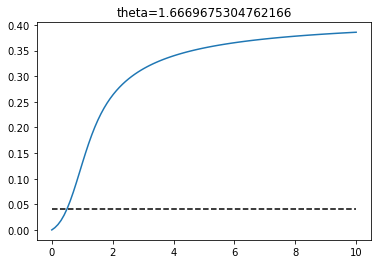

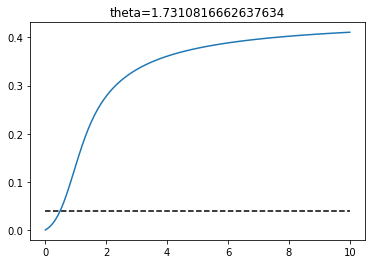

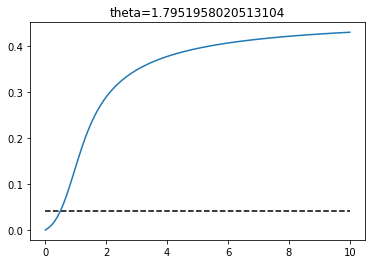

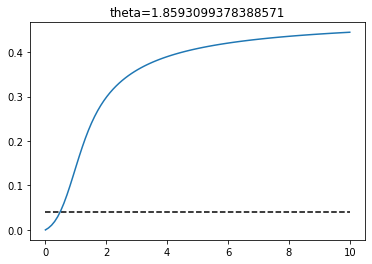

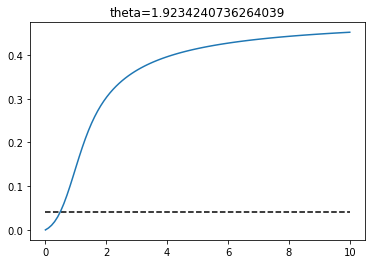

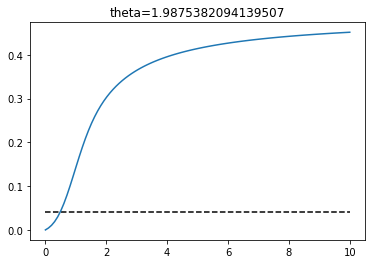

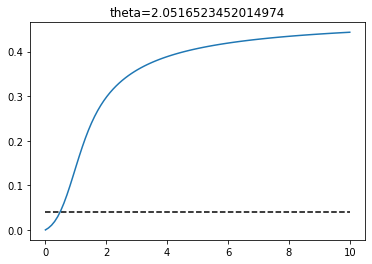

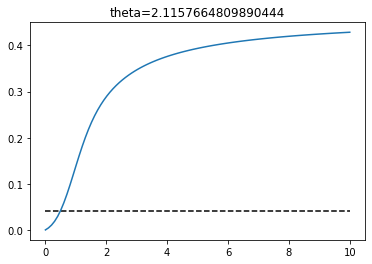

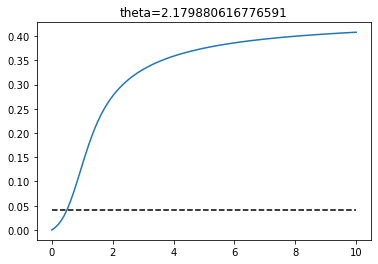

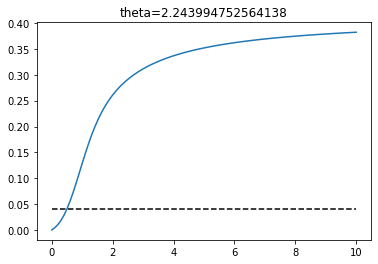

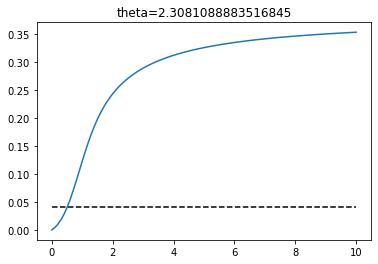

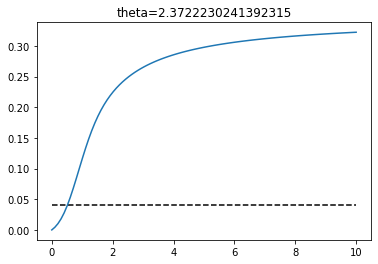

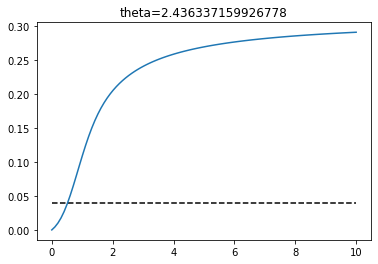

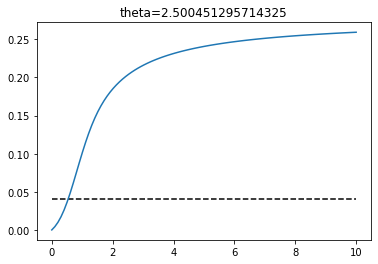

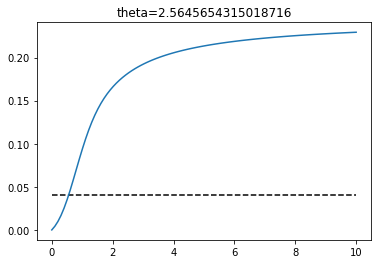

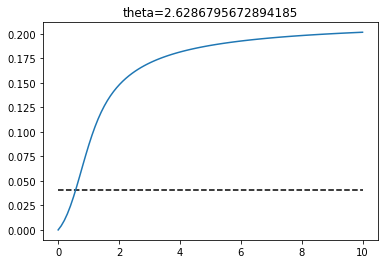

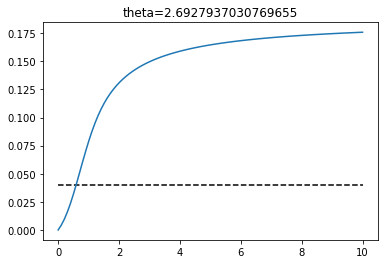

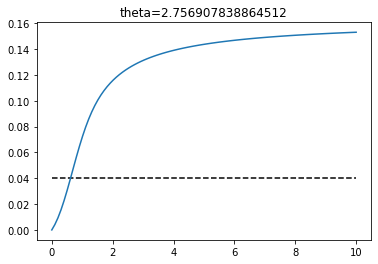

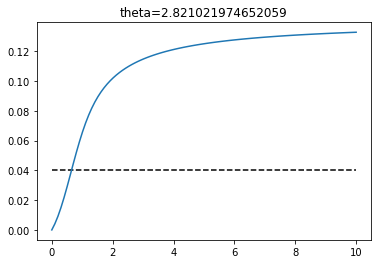

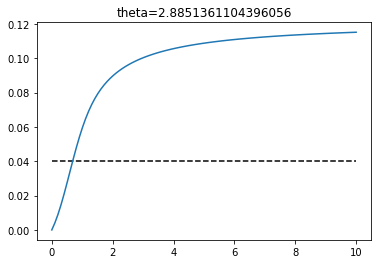

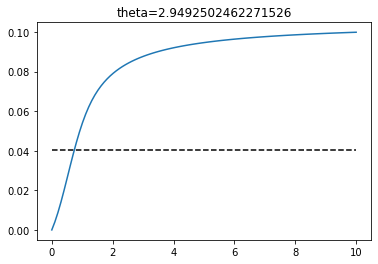

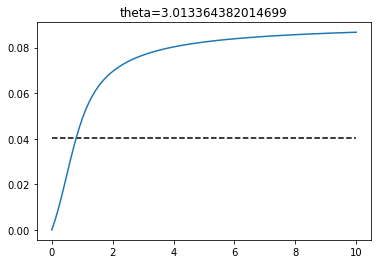

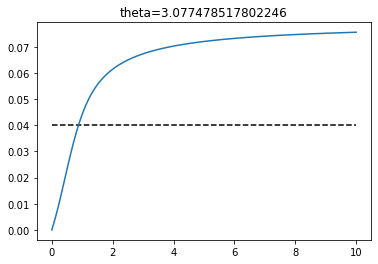

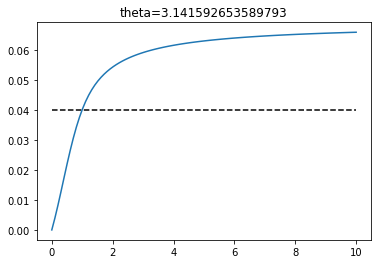

In [8]:
scheme = quadpy.c1.gauss_patterson(6)

length_edge1 = np.linalg.norm(b - a)

w1 = length_edge1 * \
     scheme.integrate(lambda t: eta(np.outer(1-t, a) + np.outer(t, b)) * t, [0, 1])

for theta in np.linspace(0, pi):
    c_ref = b + rot(theta) @ (b-a)
    
    t_tab = np.linspace(1e-10, 10, 100)
    w2_tab = []

    for t in t_tab:
        c = b + (c_ref - b) * t

        length_edge2 = np.linalg.norm(c - b)

        w2 = length_edge2 * \
             scheme.integrate(lambda t: eta(np.outer(1-t, b) + np.outer(t, c)) * (1-t), [0, 1])

        w2_tab.append(w2)
        
    plt.plot(t_tab, w2_tab)
    plt.title("theta={}".format(theta))
    plt.hlines(w1, 0, 10, colors='black', linestyles='dashed')
    plt.show();

In [ ]:
t_tab[np.where(np.abs(w2_tab - w1) < 0.0005)]

In [ ]:
def point(r, theta):
    z = r * np.exp(1j * theta)
    return np.array([np.real(z), np.imag(z)])

r_a, theta_a = 0.5, pi/4
r_b, theta_b = 0.6, 6*pi/10
r_c, theta_c = 0.4, 7*pi/8

a = point(r_a, theta_a)
b = point(r_b, theta_b)
c = point(r_c, theta_c)

plt.scatter(a[0], a[1], color='black')
plt.scatter(b[0], b[1], color='red')
plt.scatter(c[0], c[1], color='green')
plt.scatter(0, 0, color='blue');

In [ ]:
val, err = quadpy.quad(lambda t: eta(np.outer(1-t, a) + np.outer(t, b)) * (1 - t), 0, 1)
w1, err1 = np.linalg.norm(b - a) * val, err
print("w1: {}".format(w1))
print("err1: {}\n".format(err1))

theta_p = atan(- (b[0] - a[0]) / (b[1] - a[1]))

def integrand(theta):
    term1 = np.exp(-(np.linalg.norm(a) * np.cos(theta_a - theta_p) / np.cos(theta - theta_p))**2 / (2 * std**2))
    term2 = np.linalg.norm(a) * np.cos(theta_p - theta_a) / np.cos(theta_p - theta) ** 2
    term3 = np.sin(theta - theta_b) * np.cos(theta_a - theta_p) / (np.sin(theta_a - theta_b) * np.cos(theta - theta_p))
    return term1 * term2 * term3

w2, err2 = quadpy.quad(integrand, theta_a, theta_b)
print("w2: {}".format(w2))
print("err2: {}".format(err2))

In [ ]:
val, err = quadpy.quad(lambda t: eta(np.outer(1-t, a) + np.outer(t, b)), 0, 1)
w1, err1 = np.linalg.norm(b - a) * val, err
print("w1: {}".format(w1))
print("err1: {}\n".format(err1))

theta_p = atan(- (b[0] - a[0]) / (b[1] - a[1]))

def integrand(theta):
    term1 = np.exp(-(np.linalg.norm(a) * np.cos(theta_a - theta_p) / np.cos(theta - theta_p))**2 / (2 * std**2))
    term2 = np.linalg.norm(a) * np.cos(theta_p - theta_a) / np.cos(theta_p - theta) ** 2
    return term1 * term2

w2, err2 = quadpy.quad(integrand, theta_a, theta_b)
print("w2: {}".format(w2))
print("err2: {}".format(err2))

In [ ]:
def lala(theta):
    return np.sin(theta - theta_b) * np.cos(theta_a - theta_p) / (np.sin(theta_a - theta_b) * np.cos(theta - theta_p))

In [ ]:
def dist_lala(theta, b):
    r = np.linalg.norm(a) * np.cos(theta_a - theta_p) / np.cos(theta - theta_p)
    v = np.stack([r * np.cos(theta), r * np.sin(theta)], axis=1)
    return np.linalg.norm(v - b, axis=1)

In [ ]:
theta_tab = np.linspace(theta_a, theta_b, 1000)
plt.plot(theta_tab, lala(theta_tab))
plt.plot(theta_tab, 
         dist_lala(theta_tab, b) / np.linalg.norm(b - a), color='red', alpha=0.5);

# LALALALA

In [6]:
import numpy as np
import quadpy
import matplotlib.pyplot as plt

from pycheeger import triangulate, integrate_on_triangles
from math import exp, pi, cos, sin, atan, sqrt
from numba import jit, prange

In [54]:
std = 1.0


@jit(nopython=True, parallel=True)
def eta_aux(x, res):
    for i in prange(x.shape[0]):
        squared_norm = x[i, 0] ** 2 + x[i, 1] ** 2
        res[i] += exp(-squared_norm / (2 * std**2))


def eta(x):
    if x.ndim == 1:
        tmp = np.zeros(1)
        eta_aux(np.reshape(x, (1, 2)), tmp)
        res = tmp[0]
    else:
        res = np.zeros(x.shape[0])
        eta_aux(x, res)
    return res

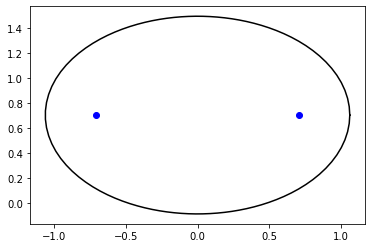

In [55]:
a = np.array([cos(pi/4), sin(pi/4)])
b = np.array([cos(3*pi/4), sin(3*pi/4)])
center = (a + b) / 2

gamma = np.linalg.norm(a - b) / 2
alpha = 1.5 * gamma
beta = sqrt(alpha**2 - gamma**2)
e = gamma / alpha

theta_tab = np.linspace(0, 2*pi, 100)
r_tab = beta / np.sqrt(1 - e**2 * np.cos(theta_tab) ** 2)
c_tab = center + np.stack([r_tab * np.cos(theta_tab), r_tab * np.sin(theta_tab)], axis=1)

plt.scatter(a[0], a[1], color='blue')
plt.scatter(b[0], b[1], color='blue')
plt.plot(c_tab[:, 0], c_tab[:, 1], 'black')
plt.show()

In [56]:
theta_tab = np.linspace(0.1, pi-0.1)
r_tab = beta / np.sqrt(1 - e**2 * np.cos(theta_tab) ** 2)
c_tab = center + np.stack([r_tab * np.cos(theta_tab), r_tab * np.sin(theta_tab)], axis=1)
val_tab = []
area_tab = []

for i in range(len(theta_tab)):
    vertices = np.stack([a, b, c_tab[i]], axis=0)
    raw_mesh = triangulate(vertices, max_triangle_area=0.005, split_boundary=True)
    triangles = raw_mesh['vertices'][raw_mesh['triangles']]
    val = np.sum(integrate_on_triangles(eta, triangles))

    l1 = np.linalg.norm(a - b)
    l2 = np.linalg.norm(b - c_tab[i])
    l3 = np.linalg.norm(a - c_tab[i])
    half_perim = (l1 + l2 + l3) / 2
    area = sqrt(half_perim * (half_perim - l1) * (half_perim - l2) * (half_perim - l3))
    
    val_tab.append(val)
    area_tab.append(area)

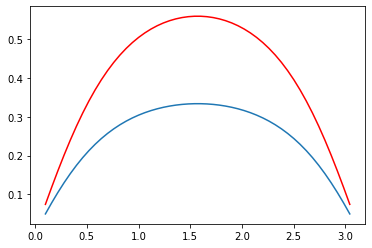

In [57]:
plt.plot(theta_tab, val_tab);
plt.plot(theta_tab, area_tab, color='red');

# LILILILILILILI